In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
import torch.backends.cudnn as cudnn
from torchsummary import summary
import os


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Convolutional Neural Network class

In [3]:
input_dim = 28*28 #input dimension
hidden_dim = 10 
out_dim = 10


class ConvolutionalNetwork(nn.Module):

    def __init__(self, input_dim, out_dim):

        super(ConvolutionalNetwork, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutaional_neural_network_layers = nn.Sequential(
                                nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), padding=1, stride=1), # (N, 1, 28, 28)
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3,3), padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Linear layer
        self.linear_layers = nn.Sequential(
                    nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                    nn.Linear(in_features=5*7*7, out_features=out_dim),
            )

        #Softmax
        self.soft = nn.Softmax(dim=1)


    # Defining the forward pass
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer
        x = self.linear_layers(x)

        x = self.soft(x)

        return x

Initialization of the model

In [4]:
model = ConvolutionalNetwork(input_dim, out_dim).to(device)

if device.type != "cpu":
  model = torch.compile(model)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)


Summery of the CNN

In [ ]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 28, 28]              50
              ReLU-2            [-1, 5, 28, 28]               0
         MaxPool2d-3            [-1, 5, 14, 14]               0
            Conv2d-4            [-1, 5, 14, 14]             230
              ReLU-5            [-1, 5, 14, 14]               0
         MaxPool2d-6              [-1, 5, 7, 7]               0
           Dropout-7                  [-1, 245]               0
            Linear-8                   [-1, 10]           2,460
           Softmax-9                   [-1, 10]               0
Total params: 2,740
Trainable params: 2,740
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.10
-----------------------------------------------

Loss function: 

In [9]:
loss_function = nn.CrossEntropyLoss()

Functions to train the model:

In [11]:
def accuracy(y_pred, y):

    pred = y_pred.detach().argmax(dim=1)
    corrects = (pred == y)
    accuracy = (corrects.sum()/corrects.size(0)).float()

    return accuracy


def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

    acc_train, acc_test = 0, 0
    running_loss = 0.0

    with torch.no_grad():

        for x_train, y_train in train_loader:

            x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

            out = model(x_train).squeeze()
            acc_train += accuracy(out, y_train)

        for x_test, y_test in test_loader:

            x_test, y_test = x_test.to(device), y_test.to(device)

            out = model(x_test).squeeze()
            loss = loss_function(out, y_test)
            running_loss += loss.item()
            acc_test += accuracy(out, y_test)

        val_loss = running_loss / len(test_loader)
        acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

    return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100, val_loss


def train(model, x, y, loss_function, optimizer):
    model.train()
    out = model(x).squeeze()

    loss = loss_function(out, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    return float(loss)

In [13]:
n_train = 8000
n_test = 350

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)


Training of the CNN for 100 epochs for all dataset sizes:

In [15]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

old_acc = []
old_train = []
old_test = []
old_acc_train = []

ratio = 50
EPOCHS = 100
n_runs = 3 #three iterations were done and avaraged 

for j in range(n_runs):

    ACCURACY_matrix = []
    TrainLOSS_matrix = []
    TestLOSS_matrix = []
    ACCURACY_train_matrix = []

    print(f"Run Number: {j+1}")

    for i in range (1, ratio+1):

        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []

        # Set the datasetsize
        n_train_loop = int(n_train * i / ratio)
        #batch_size_train_loop = int(batch_size_train * i / ratio)

        # Create the train dataset and the train loader

        dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                              transform=transform)
        dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]

        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                                  shuffle = True,  drop_last = True)


        torch._dynamo.config.cache_size_limit = 800   # <- Con una batch size di test piccola non dovrebbe più servire
        model = ConvolutionalNetwork(input_dim, out_dim).to(device)

        learning_rate = 0.1
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

        for epoch in range(1,EPOCHS+1):
            train_loss = 0

            for x_train, y_train in train_loader:
                x_train, y_train = x_train.to(device), y_train.to(device)
                loss = train(model, x_train, y_train, loss_function, optimizer)
                train_loss += loss

            train_loss /= len(train_loader)                    # we divide by the number of batches
            train_losses.append(train_loss)

            train_acc, test_acc, test_loss = evaluate(model, train_loader, test_loader)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)

            if epoch % 25 == 0:
                print("Epoch:", epoch, "Loss:", float(train_loss), "Test Loss:", test_loss, "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        # Save in ACCURACY_matrix
        ACCURACY_matrix.append(test_accuracies)
        TrainLOSS_matrix.append(train_losses)
        TestLOSS_matrix.append(test_losses)
        ACCURACY_train_matrix.append(train_accuracies)

    if j == 0:

        old_acc = ACCURACY_matrix
        old_train = TrainLOSS_matrix
        old_test = TestLOSS_matrix
        old_acc_train = ACCURACY_train_matrix

    else:

        # For old_acc and ACCURACY_matrix
        old_acc = [[old_acc[row][col] + ACCURACY_matrix[row][col] for col in range(len(old_acc[0]))] for row in range(len(old_acc))]

        # For old_train and TrainLOSS_matrix
        old_train = [[old_train[row][col] + TrainLOSS_matrix[row][col] for col in range(len(old_train[0]))] for row in range(len(old_train))]

        # For old_test and TestLOSS_matrix
        old_test = [[old_test[row][col] + TestLOSS_matrix[row][col] for col in range(len(old_test[0]))] for row in range(len(old_test))]

        # For old_acc_train and ACCURACY_train_matrix
        old_acc_train = [[old_acc_train[row][col] + ACCURACY_train_matrix[row][col] for col in range(len(old_acc_train[0]))] for row in range(len(old_acc_train))]


    print("\n")


Run Number: 1
Epoch: 25 Loss: 1.6228099942207337 Test Loss: 1.8247283697128296 data: 160 train_acc 84.375 test_acc 63.46590518951416
Epoch: 50 Loss: 1.5869925022125244 Test Loss: 1.7863508462905884 data: 160 train_acc 88.12500238418579 test_acc 66.02272391319275
Epoch: 75 Loss: 1.5869306206703186 Test Loss: 1.764471010728316 data: 160 train_acc 88.12500238418579 test_acc 68.84469389915466
Epoch: 100 Loss: 1.514939045906067 Test Loss: 1.7431047612970525 data: 160 train_acc 94.9999988079071 test_acc 72.02651500701904
Epoch: 25 Loss: 1.6197674512863158 Test Loss: 1.7489524212750522 data: 320 train_acc 84.375 test_acc 71.62878513336182
Epoch: 50 Loss: 1.5757570385932922 Test Loss: 1.6976457725871692 data: 320 train_acc 89.0625 test_acc 77.36742496490479
Epoch: 75 Loss: 1.5657692074775695 Test Loss: 1.6875463399020108 data: 320 train_acc 89.3750011920929 test_acc 76.57196521759033
Epoch: 100 Loss: 1.5595346927642821 Test Loss: 1.6940117315812544 data: 320 train_acc 89.3750011920929 test_acc

In [16]:
ACCURACY_matrix = [[element / n_runs for element in row] for row in old_acc]
TrainLOSS_matrix = [[element / n_runs for element in row] for row in old_train]
TestLOSS_matrix = [[element / n_runs for element in row] for row in old_test]
ACCURACY_train_matrix = [[element / n_runs for element in row] for row in old_acc_train]

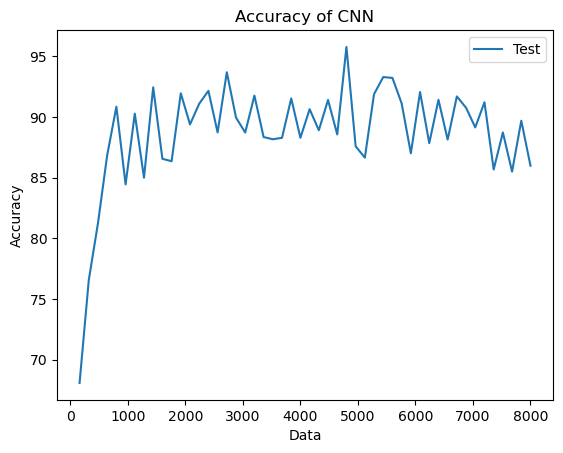

In [17]:
# Extract last non-zero values from each list
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]


# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of CNN')
plt.legend()
plt.show()

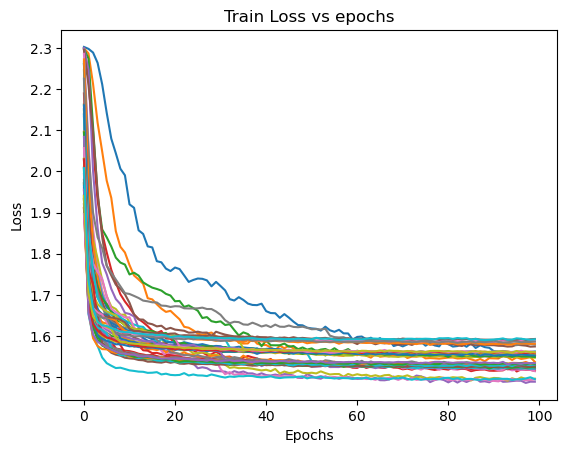

In [18]:
# Extract last non-zero values from each list
for i in range(len(TrainLOSS_matrix)):
    plt.plot(range(EPOCHS), TrainLOSS_matrix[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs epochs')
plt.show()

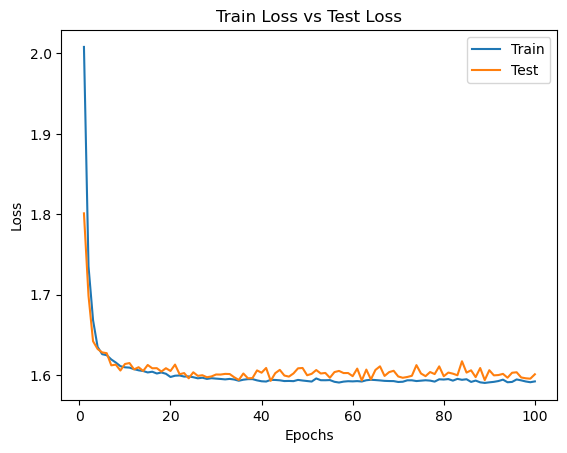

In [19]:
plt.plot(range(1, EPOCHS + 1), TrainLOSS_matrix[-1], label = "Train")
plt.plot(range(1, EPOCHS + 1), TestLOSS_matrix[-1], label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

Saving into files 

In [20]:
import numpy as np
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TestLOSS_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name3), TestLOSS_matrix)

Confusion matrix example for the last iteration

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.   0.   0.   0.03 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.   0.   0.03 0.   0.  ]
 [0.   0.   0.02 0.   0.98 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.03 0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   0.04 0.   0.   0.04 0.   0.   0.91 0.  ]
 [0.   0.   0.   0.   0.03 0.03 0.   0.05 0.   0.89]]


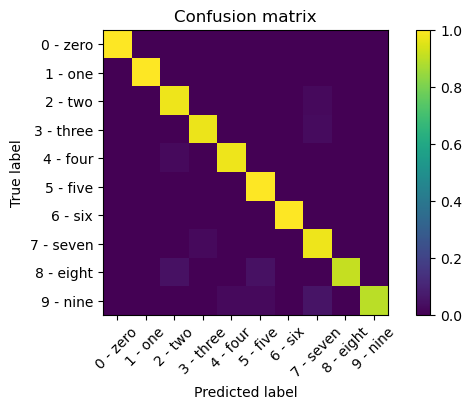

In [22]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

Accuracy for test and train sets over the dataset sizes

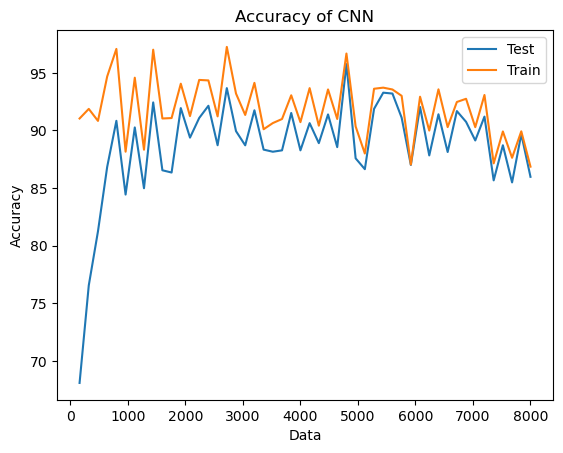

In [23]:
# Extract last non-zero values from each list
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]
last_elements_train = [sublist[-1] for sublist in ACCURACY_train_matrix]

# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.plot(data, last_elements_train, label = "Train")

plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of CNN')
plt.legend()
plt.show()

NameError: name 'test_accuracies' is not defined